# __COSAN MLIP MD simulations__
Objective: generate enough sampling to determine if the experimental solvent-dependence of COSAN is observed using three different uMLIP models: UMA-small, MACE-MP-0b2 and ORB-v3. 

Secondary objective: See if in sampling the lack of rotational invariance of ORB models is diffuminated. Inspired by the ETH Zürich team regarding rotational invariance and direct force prediction. 

### __Imports & Functions__

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

import ase.units as units
from ase import Atoms
from ase.calculators.tip3p import TIP3P, angleHOH, rOH
from ase.constraints import FixBondLengths
from ase.io.trajectory import Trajectory
from ase.io.trajectory import TrajectoryReader
from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.checkpoint import Checkpoint
import pickle

# constants
R = 8.31446261815324    

In [15]:
def analyze_energies(log_path):

    # load the data in the .log file
    raw_data = np.loadtxt(fname=log_path, skiprows=1)
    time_data = raw_data[:, 0]
    etot_data = raw_data[:, 1]
    epot_data = raw_data[:, 2]
    ekin_data = raw_data[:, 3]
    temp_data = raw_data[:, 4]

    # define the figure
    n_cols = 4
    n_rows = 1
    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(3.5*n_cols, 3.5*n_rows))
    ax1, ax2, ax3, ax4 = axes[0], axes[1], axes[2], axes[3]


    # kin
    ax1.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax1.plot(time_data, ekin_data, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
    ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
    ax1.legend(loc='best')

    # pot
    ax2.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax2.plot(time_data, epot_data, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
    ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
    ax2.legend(loc='best')

    # total
    ax3.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax3.plot(time_data, etot_data, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
    ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
    ax3.legend(loc='best')
    
    # temperature
    ax4.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax4.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    ax4.plot(time_data, temp_data, label=r'$\textnormal{total energy}$', color='black', alpha=0.9)
    ax4.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{temperature}\;(\textnormal{K})$')
    ax4.legend(loc='best')

    plt.tight_layout()
    plt.savefig('./TIP3P_Waters.png', dpi=300)
    plt.show(fig)



def compute_dihedral(frame):

    # return the BBBB dihedral
    return frame.get_dihedral(8, 4, 15, 19)


def analyze_dihedral_dist(sim_path, traj_str='.'):

    # obtain all (unordered) trajectories in sim_path
    traj_list = [x for x in os.listdir(sim_path) if ('.traj' in x) and (traj_str in x)]

    dih_pool = []
    # for each traj file, obtain the dihedrals
    for traj in traj_list:
        print(os.path.join(sim_path, traj))
        traj_obj = TrajectoryReader(os.path.join(sim_path, traj))
        
        dih_list = []
        for frame in traj_obj:
            dih_list.append(compute_dihedral(frame))

        dih_pool.append(dih_list)

    # pool all dihedrals 
    dih_pool_array = np.array(dih_pool).flatten()

    return dih_pool_array


def plot_dihedral_dist(dih_list, sim_path, bin_size=5, plot_pdf=False, T=300, true_distrib_angles=None, true_distrib_energies=None, ylim=10):

    bins = np.arange(0, 360+bin_size, bin_size)

    # generate time figure
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6., 4.))

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']

    axes.tick_params(bottom=True, top=True, left=True, right=False,direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

    _counts, _bins, _ = axes.hist(dih_list, bins=bins, density=True, edgecolor=colors[0], color='w', histtype='stepfilled')
    axes.hist(dih_list, bins=bins, density=True, color=colors[0], alpha=.08, label=r'$\textnormal{BBBB dihedral}$')    

    # labels
    axes.set(ylabel=r'$\textnormal{density (adim.)}$')
    axes.set(xlabel=r'$\textnormal{BBBB dihedral\quad(deg)}$')
    axes.legend(loc='best', prop={'size': 10})

    plt.tight_layout()
    plt.savefig(os.path.join(sim_path, 'dih_dist.png'), dpi=400)
    plt.show(fig)


    # plot the pdf according to the Boltzmann distribution using the dihedral distribution
    def _compute_dih_pdf(_bins, _counts, _T):

        # obtain the central position of each bin
        angles = []
        for i in range(len(_bins)-1):
            angles.append((_bins[i] + _bins[i+1])/2.)

        # obtain the most probable bin (minimum energy in the PES)
        N_0 = _counts[np.argmax(_counts)]

        # obtain the \DeltaE via \Delta E_{ij} = - kB * T * ln(N_j/N_i) 
        energies = []
        for N_i in _counts:
            
            ratio = np.log(N_i/N_0)
            if np.abs(ratio) != np.inf:
                DeltaE = - R * T * ratio * 0.001
            else:
                DeltaE = 1000
            energies.append(DeltaE)

        # return a set of points centered on each bin with the pdf value
        return angles, energies
    

    def _plot_dih_pdf(angles, energies, true_angles=true_distrib_angles, true_energies=true_distrib_energies):

        # generate time figure
        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6., 4.))

        # color lists
        colors = ['crimson', 'black']

        axes.tick_params(bottom=True, top=True, left=True, right=False,direction="in")
        axes.tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

        axes.plot(angles, energies, label=r'$\textnormal{' + 'MD distribution' + r'}$', color=colors[0], alpha=0.8, lw=1)
        axes.set_ylim(bottom=ylim[0], top=ylim[1])
        if true_angles is not None and true_energies is not None:
            axes.plot(true_angles, true_energies, label=r'$\textnormal{' + 'real PES' + r'}$', color=colors[1], alpha=0.8, lw=2)   

        # labels
        axes.set(ylabel=r'$\Delta E\quad\textnormal{(kJ mol)}^{-1}$')
        axes.set(xlabel=r'$\textnormal{BBBB dihedral\quad(deg, }^\circ)$')
        axes.legend(loc='best', prop={'size': 10})

        plt.tight_layout()
        plt.savefig(os.path.join(sim_path, 'dih_pdf.png'), dpi=400)
        plt.show(fig)



    if plot_pdf:
        _angles, _energies = _compute_dih_pdf(_bins, _counts, T)

        if (true_distrib_angles is not None) and (true_distrib_energies is not None):
            _plot_dih_pdf(_angles, _energies, true_angles=true_distrib_angles, true_energies=true_distrib_energies)
        else: 
            _plot_dih_pdf(_angles, _energies)


# __COSAN MD Analysis__

/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/cosan_mds/solvated_MACE-MP_0/solvated_MACE-MP_0_NVT_1.traj


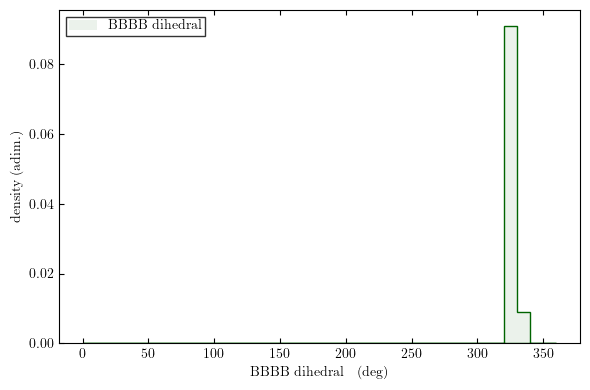

/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_45845/1352019960.py:122: RuntimeWarning: divide by zero encountered in log
  ratio = np.log(N_i/N_0)


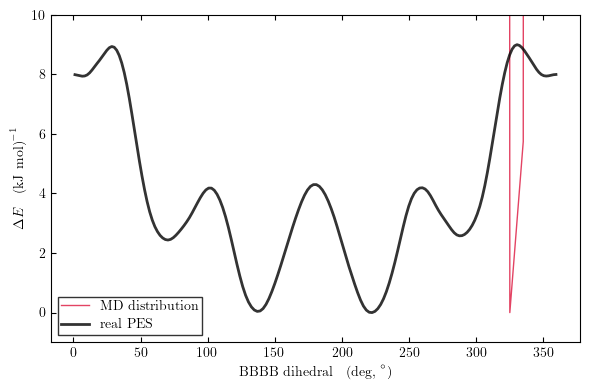

In [16]:
sim_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/cosan_mds/solvated_MACE-MP_0'
T = 300.

# extract approximate PES to compare
pes_ref_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/cosan_mds/cosan_MACE-MP_energy_rotation.txt'
raw_data = np.loadtxt(pes_ref_path, delimiter='\t')
raw_angles = raw_data[:, 0].tolist()
raw_energies = raw_data[:, 1].tolist()

# preprocess
min_angle_idx = np.argmin(raw_angles)
angles = raw_angles[min_angle_idx:] + raw_angles[:min_angle_idx]
energies = raw_energies[min_angle_idx:] + raw_energies[:min_angle_idx]


# analyze the dihedral from all trajectories
dih_list = analyze_dihedral_dist(sim_path, traj_str='NVT')

# plot the analysis
plot_dihedral_dist(dih_list, sim_path, bin_size=10, T=300, plot_pdf=True, ylim=[-1, 10], true_distrib_angles=angles, true_distrib_energies=energies)

In [ ]:
# visualize the optimization traj
traj_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/cosan_mds/solvated_MACE-MP_0.0/relaxation.traj'

load_traj = Trajectory(traj_path, 'r')
view(load_traj, viewer='ase')

In [17]:
# visualize the traj
traj_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/cosan_mds/solvated_MACE-MP_0/solvated_MACE-MP_0_NPT_3.traj'

load_traj = Trajectory(traj_path, 'r')
view(load_traj, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10

In [3]:
# visualize
cosan_solv_path = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/COSAN/simulations/cosan_solv/cosan_solv_ion.pdb'
cosan_solv = read(cosan_solv_path)

view(cosan_solv, viewer='ase')

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>